# Online Transaction Fraud Detection

## Project Title
**End-to-End Machine Learning & Deep Learning Pipeline for Fraud Detection**

---

## Objective
The objective of this project is to build a comprehensive machine learning and deep learning pipeline to **predict the probability of an online transaction being fraudulent**. We will:
1. Perform Exploratory Data Analysis (EDA)
2. Preprocess and clean the data
3. Handle class imbalance
4. Train traditional ML models (Logistic Regression, Random Forest)
5. Build a Deep Learning model (Neural Network/MLP)
6. Compare model performances
7. Make predictions on unseen test data

---

## Dataset:

- Training: 590,540 transactions with 393 features + target (isFraud)
- Test: 506,691 transactions with 393 features (prediction required)

---

## 1. Problem Statement: Fraud Detection

**Online transaction fraud** is a critical problem in the financial industry. Fraudulent transactions can lead to:
- Financial losses for customers and businesses
- Loss of customer trust
- Regulatory penalties

The challenge in fraud detection lies in:
- **Class Imbalance**: Fraudulent transactions are rare (typically <5% of all transactions)
- **Evolving Patterns**: Fraudsters constantly change their tactics
- **Real-time Detection**: Need for quick and accurate predictions

In this project, we use the `isFraud` column as our target variable:
- `isFraud = 1`: Fraudulent transaction
- `isFraud = 0`: Legitimate transaction

# 2. Import Libraries


In [42]:
# Data Manipulation and Analysis
import polars as pl
import pandas as pd  # Still needed for some sklearn compatibility
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost - Excellent for tabular data
import xgboost as xgb

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Evaluation Metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_score, 
    recall_score, 
    f1_score,
    accuracy_score
)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(None)

print("All libraries imported successfully!")
print(f"Polars version: {pl.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print("\n✅ Memory-efficient setup: Using Class Weights (No SMOTE)")

All libraries imported successfully!
Polars version: 1.33.1
XGBoost version: 3.1.2
TensorFlow version: 2.20.0

✅ Memory-efficient setup: Using Class Weights (No SMOTE)


# 3. Load Dataset


In [43]:
# Load the training dataset using Polars (much faster for large files)
train_df = pl.read_csv('finalterm_folder/train_transaction.csv')

# Load the test dataset
test_df = pl.read_csv('finalterm_folder/test_transaction.csv')

# Display dataset shapes
print("=" * 60)
print("DATASET SHAPES")
print("=" * 60)
print(f"Training Dataset Shape: {train_df.shape}")
print(f"  - Rows (Transactions): {train_df.shape[0]:,}")
print(f"  - Columns (Features): {train_df.shape[1]}")
print()
print(f"Test Dataset Shape: {test_df.shape}")
print(f"  - Rows (Transactions): {test_df.shape[0]:,}")
print(f"  - Columns (Features): {test_df.shape[1]}")
print("=" * 60)

DATASET SHAPES
Training Dataset Shape: (590540, 394)
  - Rows (Transactions): 590,540
  - Columns (Features): 394

Test Dataset Shape: (506691, 393)
  - Rows (Transactions): 506,691
  - Columns (Features): 393


In [44]:
# Display first few rows of training data
print("TRAINING DATA - First 5 Rows:")
print("=" * 60)
train_df.head()

TRAINING DATA - First 5 Rows:


TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
i64,i64,i64,f64,str,i64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2987000,0,86400,68.5,"""W""",13926,null,150.0,"""discover""",142.0,"""credit""",315.0,87.0,19.0,null,null,null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,null,13.0,null,null,null,…,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987001,0,86401,29.0,"""W""",2755,404.0,150.0,"""mastercard""",102.0,"""credit""",325.0,87.0,null,null,"""gmail.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,null,null,0.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987002,0,86469,59.0,"""W""",4663,490.0,150.0,"""visa""",166.0,"""debit""",330.0,87.0,287.0,null,"""outlook.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,null,null,0.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987003,0,86499,50.0,"""W""",18132,567.0,150.0,"""mastercard""",117.0,"""debit""",476.0,87.0,null,null,"""yahoo.com""",null,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,null,…,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987004,0,86506,50.0,"""H""",4497,514.0,150.0,"""mastercard""",102.0,"""credit""",420.0,87.0,null,null,"""gmail.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,null,null,null,null,null,…,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Display first few rows of test data
print("TEST DATA - First 5 Rows:")
print("=" * 60)
test_df.head()

TEST DATA - First 5 Rows:


TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
i64,i64,f64,str,i64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3663549,18403224,31.95,"""W""",10409,111.0,150.0,"""visa""",226.0,"""debit""",170.0,87.0,1.0,null,"""gmail.com""",null,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,null,null,…,0.0,0.0,1.0,0.0,47.950001,0.0,0.0,47.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663550,18403263,49.0,"""W""",4272,111.0,150.0,"""visa""",226.0,"""debit""",299.0,87.0,4.0,null,"""aol.com""",null,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,null,null,…,0.0,0.0,1.0,0.0,280.0,77.0,0.0,280.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663551,18403310,171.0,"""W""",4476,574.0,150.0,"""visa""",226.0,"""debit""",472.0,87.0,2635.0,null,"""hotmail.com""",null,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,null,null,…,0.0,0.0,1.0,0.0,1321.0,0.0,0.0,1058.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663552,18403310,284.95,"""W""",10989,360.0,150.0,"""visa""",166.0,"""debit""",205.0,87.0,17.0,null,"""gmail.com""",null,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663553,18403317,67.95,"""W""",18018,452.0,150.0,"""mastercard""",117.0,"""debit""",264.0,87.0,6.0,null,"""gmail.com""",null,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,null,null,…,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [46]:
# Display column names and data types
print("COLUMN INFORMATION - Training Data:")
print("=" * 60)
print(train_df.schema)
print()
print(f"Total columns: {len(train_df.columns)}")

COLUMN INFORMATION - Training Data:
Schema([('TransactionID', Int64), ('isFraud', Int64), ('TransactionDT', Int64), ('TransactionAmt', Float64), ('ProductCD', String), ('card1', Int64), ('card2', Float64), ('card3', Float64), ('card4', String), ('card5', Float64), ('card6', String), ('addr1', Float64), ('addr2', Float64), ('dist1', Float64), ('dist2', Float64), ('P_emaildomain', String), ('R_emaildomain', String), ('C1', Float64), ('C2', Float64), ('C3', Float64), ('C4', Float64), ('C5', Float64), ('C6', Float64), ('C7', Float64), ('C8', Float64), ('C9', Float64), ('C10', Float64), ('C11', Float64), ('C12', Float64), ('C13', Float64), ('C14', Float64), ('D1', Float64), ('D2', Float64), ('D3', Float64), ('D4', Float64), ('D5', Float64), ('D6', Float64), ('D7', Float64), ('D8', Float64), ('D9', Float64), ('D10', Float64), ('D11', Float64), ('D12', Float64), ('D13', Float64), ('D14', Float64), ('D15', Float64), ('M1', String), ('M2', String), ('M3', String), ('M4', String), ('M5', String)

# 4. Exploratory Data Analysis (EDA)


In [47]:
# Basic Statistics for Numerical Features
print("BASIC STATISTICS - Numerical Features:")
print("=" * 60)
train_df.describe()

BASIC STATISTICS - Numerical Features:


statistic,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
str,f64,f64,f64,f64,str,f64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",590540.0,590540.0,590540.0,590540.0,"""590540""",590540.0,581607.0,588975.0,"""588963""",586281.0,"""588969""",524834.0,524834.0,238269.0,37627.0,"""496084""","""137291""",590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,…,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,589271.0,589271.0,589271.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0,82351.0
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0,8933.0,1565.0,"""1577""",4259.0,"""1571""",65706.0,65706.0,352271.0,552913.0,"""94456""","""453249""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1269.0,280797.0,262878.0,168922.0,309841.0,…,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,1269.0,1269.0,1269.0,12.0,12.0,12.0,12.0,12.0,12.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0,508189.0
"""mean""",3282269.5,0.03499,7.3723e6,135.027176,null,9898.734658,362.555488,153.194925,null,199.278897,null,290.733794,86.80063,118.50218,231.855423,null,null,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.48024,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,…,0.28314,0.264208,1.000007,139.748713,408.682375,230.41318,10.995986,118.195658,4.202175,39.17391,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.85104,0.296633,0.33679,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
"""std""",170474.358321,0.183755,4.6172e6,239.162522,null,4901.170153,157.793246,11.336444,null,41.244453,null,101.741072,2.690623,371.872026,529.053494,null,null,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,…,0.623608,0.528238,0.002603,2348.849634,4391.992977,3021.924247,116.254277,352.983093,102.374938,172.128339,95.90297,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.57692,668.486833,1095.034387,814.946722
"""min""",2.987e6,0.0,86400.0,0.251,"""C""",1000.0,100.0,100.0,"""american express""",100.0,"""charge card""",100.0,10.0,0.0,0.0,"""aim.com""","""aim.com""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-122.0,0.0,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.134635e6,0.0,3.027065e6,43.321,null,6019.0,214.0,150.0,null,166.0,null,204.0,87.0,3.0,7.0,null,null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,26.0,1.0,0.0,1.0,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

TARGET VARIABLE DISTRIBUTION:
Not Fraud (0): 569,877 transactions (96.50%)
Fraud (1):     20,663 transactions (3.50%)

Imbalance Ratio: 1:27.6


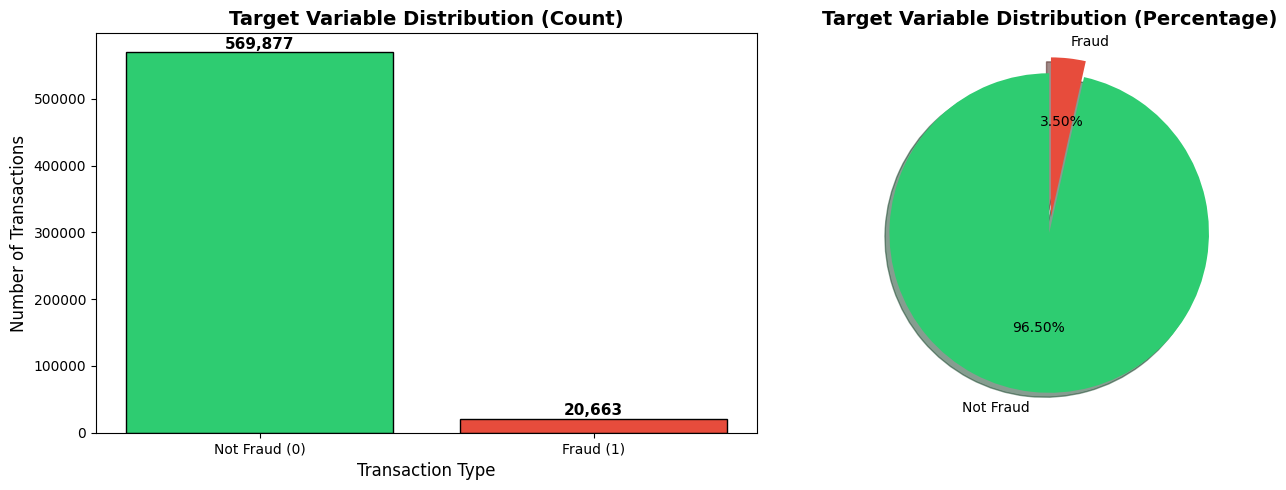


OBSERVATION: The dataset is HIGHLY IMBALANCED!
   This is typical in fraud detection scenarios.


In [48]:
# Target Variable Distribution (isFraud)
print("TARGET VARIABLE DISTRIBUTION:")
print("=" * 60)

fraud_counts = train_df['isFraud'].value_counts().sort('isFraud')
fraud_total = train_df.shape[0]

not_fraud_count = fraud_counts.filter(pl.col('isFraud') == 0)['count'][0]
fraud_count = fraud_counts.filter(pl.col('isFraud') == 1)['count'][0]

not_fraud_pct = (not_fraud_count / fraud_total) * 100
fraud_pct = (fraud_count / fraud_total) * 100

print(f"Not Fraud (0): {not_fraud_count:,} transactions ({not_fraud_pct:.2f}%)")
print(f"Fraud (1):     {fraud_count:,} transactions ({fraud_pct:.2f}%)")
print()
print(f"Imbalance Ratio: 1:{not_fraud_count/fraud_count:.1f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
counts = [not_fraud_count, fraud_count]
bars = axes[0].bar(['Not Fraud (0)', 'Fraud (1)'], counts, color=colors, edgecolor='black')
axes[0].set_title('Target Variable Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Transactions', fontsize=12)
axes[0].set_xlabel('Transaction Type', fontsize=12)

# Add count labels on bars
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=['Not Fraud', 'Fraud'], autopct='%1.2f%%',
            colors=colors, explode=(0, 0.1), shadow=True, startangle=90)
axes[1].set_title('Target Variable Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nOBSERVATION: The dataset is HIGHLY IMBALANCED!")
print("   This is typical in fraud detection scenarios.")

MISSING VALUE ANALYSIS:
Columns with missing values: 374

shape: (374, 3)
┌────────┬───────────────┬────────────────────┐
│ Column ┆ Missing Count ┆ Missing Percentage │
│ ---    ┆ ---           ┆ ---                │
│ str    ┆ i64           ┆ f64                │
╞════════╪═══════════════╪════════════════════╡
│ dist2  ┆ 552913        ┆ 93.628374          │
│ D7     ┆ 551623        ┆ 93.40993           │
│ D13    ┆ 528588        ┆ 89.509263          │
│ D14    ┆ 528353        ┆ 89.469469          │
│ D12    ┆ 525823        ┆ 89.041047          │
│ D6     ┆ 517353        ┆ 87.606767          │
│ D8     ┆ 515614        ┆ 87.31229           │
│ D9     ┆ 515614        ┆ 87.31229           │
│ V138   ┆ 508595        ┆ 86.123717          │
│ V139   ┆ 508595        ┆ 86.123717          │
│ V140   ┆ 508595        ┆ 86.123717          │
│ V141   ┆ 508595        ┆ 86.123717          │
│ V142   ┆ 508595        ┆ 86.123717          │
│ V146   ┆ 508595        ┆ 86.123717          │
│ V147   ┆ 508

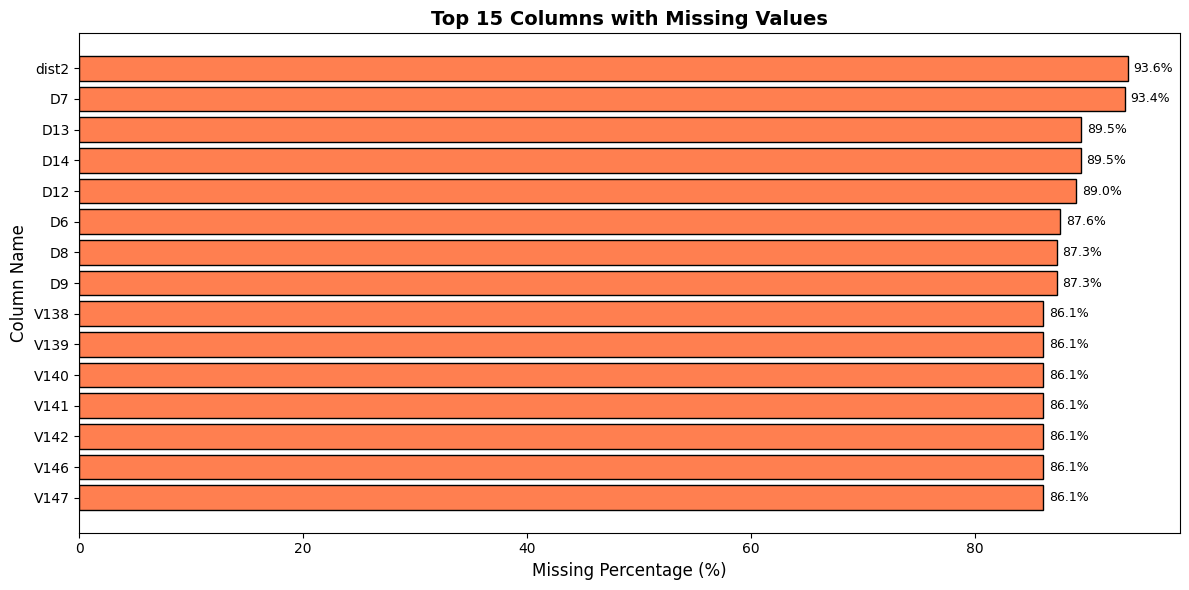


Total missing values in training data: 95,566,686


In [49]:
# Missing Value Analysis
print("MISSING VALUE ANALYSIS:")
print("=" * 60)

# Calculate missing values using Polars
null_counts = train_df.null_count()
total_rows = train_df.shape[0]

# Create a DataFrame for missing values
missing_data = []
for col in train_df.columns:
    null_count = null_counts[col][0]
    if null_count > 0:
        missing_data.append({
            'Column': col,
            'Missing Count': null_count,
            'Missing Percentage': (null_count / total_rows) * 100
        })

if len(missing_data) > 0:
    missing_df = pl.DataFrame(missing_data).sort('Missing Percentage', descending=True)
    
    print(f"Columns with missing values: {len(missing_data)}")
    print()
    print(missing_df)
    
    # Visualization of top missing columns
    top_missing = missing_df.head(15)
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_missing['Column'].to_list(), 
                    top_missing['Missing Percentage'].to_list(), 
                    color='coral', edgecolor='black')
    plt.xlabel('Missing Percentage (%)', fontsize=12)
    plt.ylabel('Column Name', fontsize=12)
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add percentage labels
    for bar, pct in zip(bars, top_missing['Missing Percentage'].to_list()):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

# Total null count
total_nulls = sum(null_counts.row(0))
print()
print(f"Total missing values in training data: {total_nulls:,}")

In [50]:
# Identify categorical and numerical columns using Polars schema
categorical_cols = [col for col, dtype in train_df.schema.items() if dtype == pl.Utf8 or dtype == pl.Categorical]
numerical_cols = [col for col, dtype in train_df.schema.items() 
                  if dtype in [pl.Int64, pl.Int32, pl.Float64, pl.Float32, pl.Int8, pl.Int16]]

# Remove target from numerical columns
if 'isFraud' in numerical_cols:
    numerical_cols.remove('isFraud')

print("FEATURE TYPES:")
print("=" * 60)
print(f"Categorical Features: {len(categorical_cols)}")
print(f"Numerical Features: {len(numerical_cols)}")
print()
print("Categorical Columns:")
print(categorical_cols)
print()
print("Sample Numerical Columns (first 20):")
print(numerical_cols[:20])

FEATURE TYPES:
Categorical Features: 14
Numerical Features: 379

Categorical Columns:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

Sample Numerical Columns (first 20):
['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


# 5. Data Preprocessing


In [51]:
# Store TransactionID for later use (if exists)
if 'TransactionID' in train_df.columns:
    train_transaction_ids = train_df['TransactionID'].clone()
    test_transaction_ids = test_df['TransactionID'].clone()
    train_df = train_df.drop('TransactionID')
    test_df = test_df.drop('TransactionID')
    print("TransactionID stored and removed from features")
else:
    # If no TransactionID, create one
    train_transaction_ids = pl.Series(range(train_df.shape[0]))
    test_transaction_ids = pl.Series(range(test_df.shape[0]))
    print("TransactionID not found, created sequential IDs")

# Separate target variable
y = train_df['isFraud'].clone()
X = train_df.drop('isFraud')

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test data shape: {test_df.shape}")

TransactionID stored and removed from features
Features shape: (590540, 392)
Target shape: (590540,)
Test data shape: (506691, 392)


## 5.1 Handling Missing Values



In [52]:
# Identify categorical and numerical columns
categorical_cols = [col for col, dtype in X.schema.items() if dtype == pl.Utf8 or dtype == pl.Categorical]
numerical_cols = [col for col, dtype in X.schema.items() 
                  if dtype in [pl.Int64, pl.Int32, pl.Float64, pl.Float32, pl.Int8, pl.Int16]]

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Handle missing values in numerical columns using Polars
print("\nHandling missing values in NUMERICAL columns...")

# Fill numerical columns with median
for col in numerical_cols:
    median_val = X[col].median()
    X = X.with_columns(pl.col(col).fill_null(median_val))
    
    # Apply same median to test data
    test_df = test_df.with_columns(pl.col(col).fill_null(median_val))

print(f"Numerical columns imputed with median values")

# Handle missing values in categorical columns
print("\nHandling missing values in CATEGORICAL columns...")
for col in categorical_cols:
    X = X.with_columns(pl.col(col).fill_null('Unknown'))
    test_df = test_df.with_columns(pl.col(col).fill_null('Unknown'))

print(f"Categorical columns imputed with 'Unknown'")

# Verify no missing values remain
train_nulls = sum(X.null_count().row(0))
test_nulls = sum(test_df.null_count().row(0))

print(f"\nMissing values after imputation:")
print(f"   Training data: {train_nulls}")
print(f"   Test data: {test_nulls}")

Categorical columns: 14
Numerical columns: 378

Handling missing values in NUMERICAL columns...
Numerical columns imputed with median values

Handling missing values in CATEGORICAL columns...
Categorical columns imputed with 'Unknown'

Missing values after imputation:
   Training data: 0
   Test data: 0


## 5.2 Encoding Categorical Features


In [53]:
# Label Encoding for categorical columns
print("Encoding categorical features using Label Encoding...")
print("=" * 60)

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    # Combine train and test data to fit encoder
    combined = pl.concat([X[col], test_df[col]]).cast(pl.Utf8).to_list()
    le.fit(combined)
    
    # Transform both datasets
    X = X.with_columns(
        pl.Series(name=col, values=le.transform(X[col].cast(pl.Utf8).to_list())).cast(pl.Int64)
    )
    test_df = test_df.with_columns(
        pl.Series(name=col, values=le.transform(test_df[col].cast(pl.Utf8).to_list())).cast(pl.Int64)
    )
    
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} unique values encoded")

print()
print(f"Total {len(categorical_cols)} categorical columns encoded!")
print(f"   Label encoders stored for inverse transformation if needed.")

Encoding categorical features using Label Encoding...
  - ProductCD: 5 unique values encoded
  - card4: 5 unique values encoded
  - card6: 5 unique values encoded
  - P_emaildomain: 61 unique values encoded
  - R_emaildomain: 61 unique values encoded
  - M1: 3 unique values encoded
  - M2: 3 unique values encoded
  - M3: 3 unique values encoded
  - M4: 4 unique values encoded
  - M5: 3 unique values encoded
  - M6: 3 unique values encoded
  - M7: 3 unique values encoded
  - M8: 3 unique values encoded
  - M9: 3 unique values encoded

Total 14 categorical columns encoded!
   Label encoders stored for inverse transformation if needed.


## 5.3 Feature Scaling


In [54]:
# Feature Scaling using StandardScaler
print("Scaling features using StandardScaler...")

scaler = StandardScaler()

# Convert Polars to numpy for sklearn compatibility
X_numpy = X.to_numpy()
test_numpy = test_df.to_numpy()

# Fit on training data and transform both train and test
X_scaled = scaler.fit_transform(X_numpy)
test_scaled = scaler.transform(test_numpy)

# Convert back to Polars DataFrame for consistent handling
X_scaled = pl.DataFrame(X_scaled, schema=X.columns)
test_scaled = pl.DataFrame(test_scaled, schema=test_df.columns)

print("Feature scaling completed!")
print(f"   Training data shape: {X_scaled.shape}")
print(f"   Test data shape: {test_scaled.shape}")

# Show sample statistics after scaling
print("\nSample statistics after scaling (first 5 columns):")
print(X_scaled.select(X_scaled.columns[:5]).describe())

Scaling features using StandardScaler...
Feature scaling completed!
   Training data shape: (590540, 392)
   Test data shape: (506691, 392)

Sample statistics after scaling (first 5 columns):
shape: (9, 6)
┌────────────┬───────────────┬────────────────┬────────────┬────────────┬────────────┐
│ statistic  ┆ TransactionDT ┆ TransactionAmt ┆ ProductCD  ┆ card1      ┆ card2      │
│ ---        ┆ ---           ┆ ---            ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64           ┆ f64            ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪═══════════════╪════════════════╪════════════╪════════════╪════════════╡
│ count      ┆ 590540.0      ┆ 590540.0       ┆ 590540.0   ┆ 590540.0   ┆ 590540.0   │
│ null_count ┆ 0.0           ┆ 0.0            ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ mean       ┆ -8.4345e-17   ┆ 2.9106e-17     ┆ 1.4482e-16 ┆ 7.6813e-17 ┆ 4.3388e-17 │
│ std        ┆ 1.000001      ┆ 1.000001       ┆ 1.000001   ┆ 1.000001   ┆ 1.000001   │
│ min      

## 5.4 Train-Validation Split

- **Training Set (80%)**: Used to train the models
- **Validation Set (20%)**: Used to evaluate model performance


In [55]:
# Split data into training and validation sets
# Convert to numpy for sklearn compatibility
X_scaled_np = X_scaled.to_numpy()
y_np = y.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled_np, y_np, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_np
)

print("DATA SPLIT COMPLETE:")
print("=" * 60)
print(f"Training Set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_scaled_np)*100:.1f}%)")
print(f"Validation Set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_scaled_np)*100:.1f}%)")
print()
print("Target Distribution in Sets:")
print(f"   Training - Fraud: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"   Validation - Fraud: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print()
print("Stratified split ensures similar fraud ratio in both sets!")

DATA SPLIT COMPLETE:
Training Set:   472,432 samples (80.0%)
Validation Set: 118,108 samples (20.0%)

Target Distribution in Sets:
   Training - Fraud: 16,530 (3.50%)
   Validation - Fraud: 4,133 (3.50%)

Stratified split ensures similar fraud ratio in both sets!


# 6. Handling Class Imbalance


HANDLING CLASS IMBALANCE WITH CLASS WEIGHTS:

Class Distribution in Training Set:
   Total samples: 472,432
   Not Fraud (0): 455,902 (96.50%)
   Fraud (1): 16,530 (3.50%)

Computed Class Weights:
   Not Fraud (0): 0.5181
   Fraud (1): 14.2901

Fraud class will be weighted 27.6x more than Not Fraud!

✅ Using class_weight='balanced' in models instead of SMOTE
   This is more memory-efficient for large datasets!


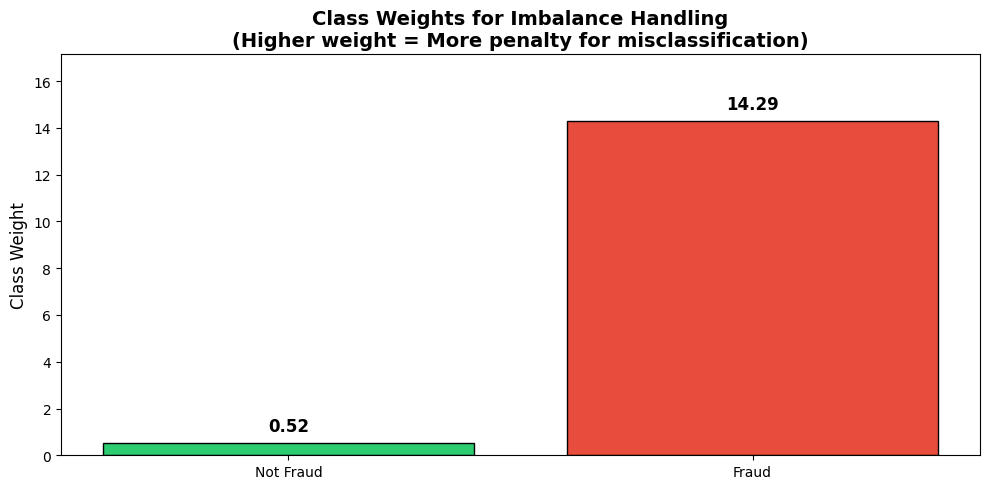

In [56]:
# Handle class imbalance using Class Weights (Memory Efficient Alternative to SMOTE)
print("HANDLING CLASS IMBALANCE WITH CLASS WEIGHTS:")
print("=" * 60)

print("\nClass Distribution in Training Set:")
print(f"   Total samples: {len(y_train):,}")
print(f"   Not Fraud (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"   Fraud (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

# Calculate class weights manually for visualization
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\nComputed Class Weights:")
print(f"   Not Fraud (0): {class_weight_dict[0]:.4f}")
print(f"   Fraud (1): {class_weight_dict[1]:.4f}")
print(f"\nFraud class will be weighted {class_weight_dict[1]/class_weight_dict[0]:.1f}x more than Not Fraud!")

# We will use the ORIGINAL training data with class weights
# No need for SMOTE - saves memory!
X_train_resampled = X_train  # Use original data
y_train_resampled = y_train  # Use original labels

print("\n✅ Using class_weight='balanced' in models instead of SMOTE")
print("   This is more memory-efficient for large datasets!")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71', '#e74c3c']
class_names = ['Not Fraud', 'Fraud']
weights = [class_weight_dict[0], class_weight_dict[1]]

bars = ax.bar(class_names, weights, color=colors, edgecolor='black')
ax.set_ylabel('Class Weight', fontsize=12)
ax.set_title('Class Weights for Imbalance Handling\n(Higher weight = More penalty for misclassification)', 
             fontsize=14, fontweight='bold')
for bar, w in zip(bars, weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{w:.2f}', ha='center', fontweight='bold', fontsize=12)
ax.set_ylim(0, max(weights) * 1.2)
plt.tight_layout()
plt.show()

# 7. Traditional Machine Learning Models


In [57]:
# Helper function to evaluate and display model results
def evaluate_model(model, X_val, y_val, model_name):
    """
    Evaluate a model and return metrics
    """
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # Print results
    print(f"\n{model_name} - EVALUATION RESULTS:")
    print("=" * 60)
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Store results for comparison
results = []
trained_models = {}

print("Evaluation function defined!")

Evaluation function defined!


## 7.1 Logistic Regression


In [58]:
# Logistic Regression - Memory Efficient Training (No GridSearchCV)
print("LOGISTIC REGRESSION - Training")
print("=" * 60)

# Initialize model with good parameters and class_weight='balanced'
# Removing GridSearchCV to avoid memory issues with large dataset
lr_model = LogisticRegression(
    C=0.1,                    # Regularization strength
    solver='lbfgs',           # Good for large datasets
    max_iter=1000,            # Ensure convergence
    class_weight='balanced',  # Handle class imbalance automatically
    random_state=42,
    n_jobs=1                  # Single job to save memory
)

print("Using class_weight='balanced' to handle class imbalance")
print("Training Logistic Regression (memory-efficient mode)...")

# Fit directly on training data
lr_model.fit(X_train_resampled, y_train_resampled)

print("✅ Training complete!")

# Store model
trained_models['Logistic Regression'] = lr_model

# Evaluate on validation set
lr_results = evaluate_model(lr_model, X_val, y_val, 'Logistic Regression')
results.append(lr_results)

LOGISTIC REGRESSION - Training
Using class_weight='balanced' to handle class imbalance
Training Logistic Regression (memory-efficient mode)...
✅ Training complete!

Logistic Regression - EVALUATION RESULTS:
   Accuracy:  0.8243
   Precision: 0.1342
   Recall:    0.7372
   F1-Score:  0.2270
   ROC-AUC:   0.8604

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.13      0.74      0.23      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.78      0.56    118108
weighted avg       0.96      0.82      0.88    118108



## 7.2 Random Forest Classifier


In [59]:
# Random Forest - Memory Efficient Training (No GridSearchCV)
print("RANDOM FOREST - Training")
print("=" * 60)

# Initialize model with good parameters and class_weight='balanced'
# Using fewer trees and limited depth to save memory
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=15,             # Limit depth to prevent memory explosion
    min_samples_split=5,      # Minimum samples to split
    min_samples_leaf=2,       # Minimum samples in leaf
    class_weight='balanced',  # Handle class imbalance automatically
    random_state=42,
    n_jobs=1                  # Single job to save memory
)

print("Using class_weight='balanced' to handle class imbalance")
print("Training Random Forest (memory-efficient mode)...")
print("This may take a few minutes...")

# Fit directly on training data
rf_model.fit(X_train_resampled, y_train_resampled)

print("✅ Training complete!")

# Store model
trained_models['Random Forest'] = rf_model

# Evaluate on validation set
rf_results = evaluate_model(rf_model, X_val, y_val, 'Random Forest')
results.append(rf_results)

RANDOM FOREST - Training
Using class_weight='balanced' to handle class imbalance
Training Random Forest (memory-efficient mode)...
This may take a few minutes...
✅ Training complete!

Random Forest - EVALUATION RESULTS:
   Accuracy:  0.9291
   Precision: 0.2897
   Recall:    0.7065
   F1-Score:  0.4109
   ROC-AUC:   0.9110

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    113975
           1       0.29      0.71      0.41      4133

    accuracy                           0.93    118108
   macro avg       0.64      0.82      0.69    118108
weighted avg       0.96      0.93      0.94    118108



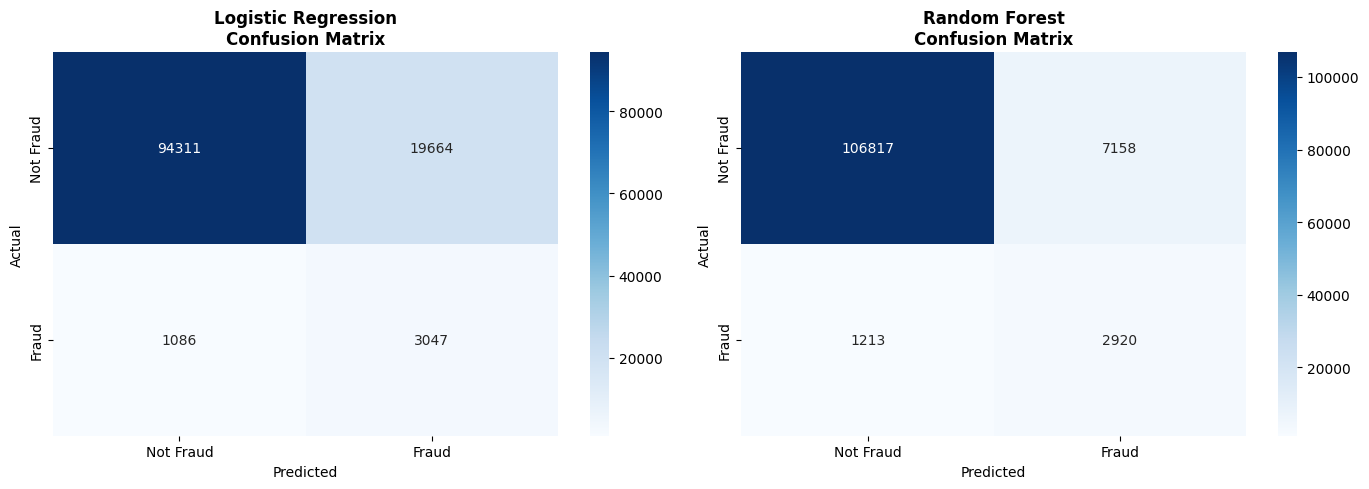

In [60]:
# Confusion Matrix Visualization for ML Models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

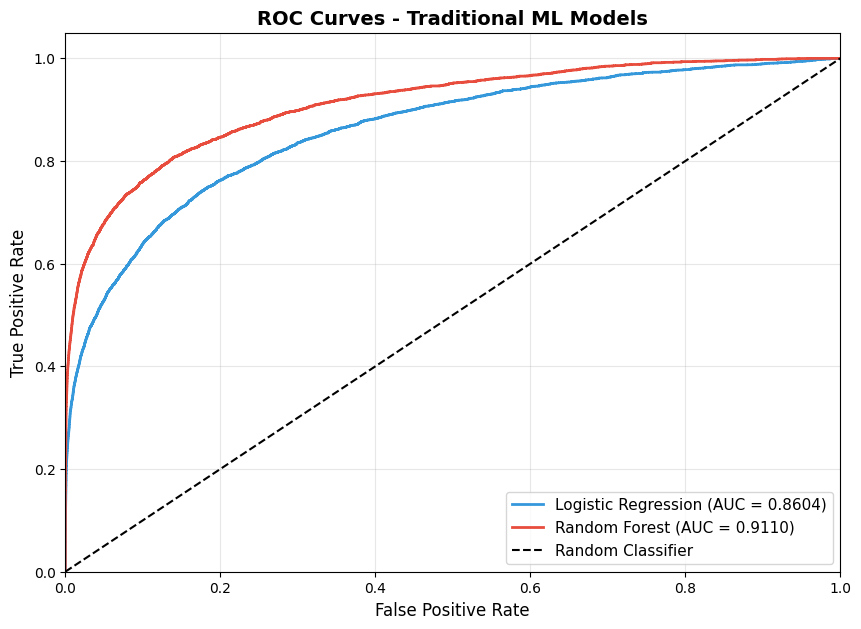

In [61]:
# ROC Curve Comparison for ML Models
plt.figure(figsize=(10, 7))

colors = ['#3498db', '#e74c3c']

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[idx], linewidth=2,
             label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Traditional ML Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# 8. XGBoost Model


In [62]:
# XGBoost - Memory Efficient Training (No GridSearchCV)
print("XGBOOST - Training")
print("=" * 60)

# Calculate scale_pos_weight for class imbalance
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f"Scale pos weight: {scale_pos_weight:.2f} (to handle {pos_count:,} fraud vs {neg_count:,} not fraud)")

# Initialize XGBoost model with good parameters
# No GridSearchCV to avoid memory issues
xgb_model = xgb.XGBClassifier(
    n_estimators=150,                    # Number of boosting rounds
    max_depth=6,                         # Tree depth
    learning_rate=0.05,                  # Step size
    subsample=0.8,                       # Sample ratio for each tree
    colsample_bytree=0.8,                # Feature ratio for each tree
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,   # Handle class imbalance
    use_label_encoder=False,
    random_state=42,
    n_jobs=1                             # Single job to save memory
)

print("\nTraining XGBoost (memory-efficient mode)...")
print("This may take a few minutes...")

# Fit directly on training data with early stopping using validation set
xgb_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val, y_val)],
    verbose=50  # Print progress every 50 rounds
)

print("✅ Training complete!")

# Store model
trained_models['XGBoost'] = xgb_model

# Evaluate on validation set
xgb_results = evaluate_model(xgb_model, X_val, y_val, 'XGBoost')
results.append(xgb_results)

XGBOOST - Training
Scale pos weight: 27.58 (to handle 16,530 fraud vs 455,902 not fraud)

Training XGBoost (memory-efficient mode)...
This may take a few minutes...
[0]	validation_0-auc:0.84010
[50]	validation_0-auc:0.89234
[100]	validation_0-auc:0.91026
[149]	validation_0-auc:0.92020
✅ Training complete!

XGBoost - EVALUATION RESULTS:
   Accuracy:  0.8847
   Precision: 0.2049
   Recall:    0.7970
   F1-Score:  0.3260
   ROC-AUC:   0.9202

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113975
           1       0.20      0.80      0.33      4133

    accuracy                           0.88    118108
   macro avg       0.60      0.84      0.63    118108
weighted avg       0.96      0.88      0.92    118108



XGBOOST FEATURE IMPORTANCE (Top 20)


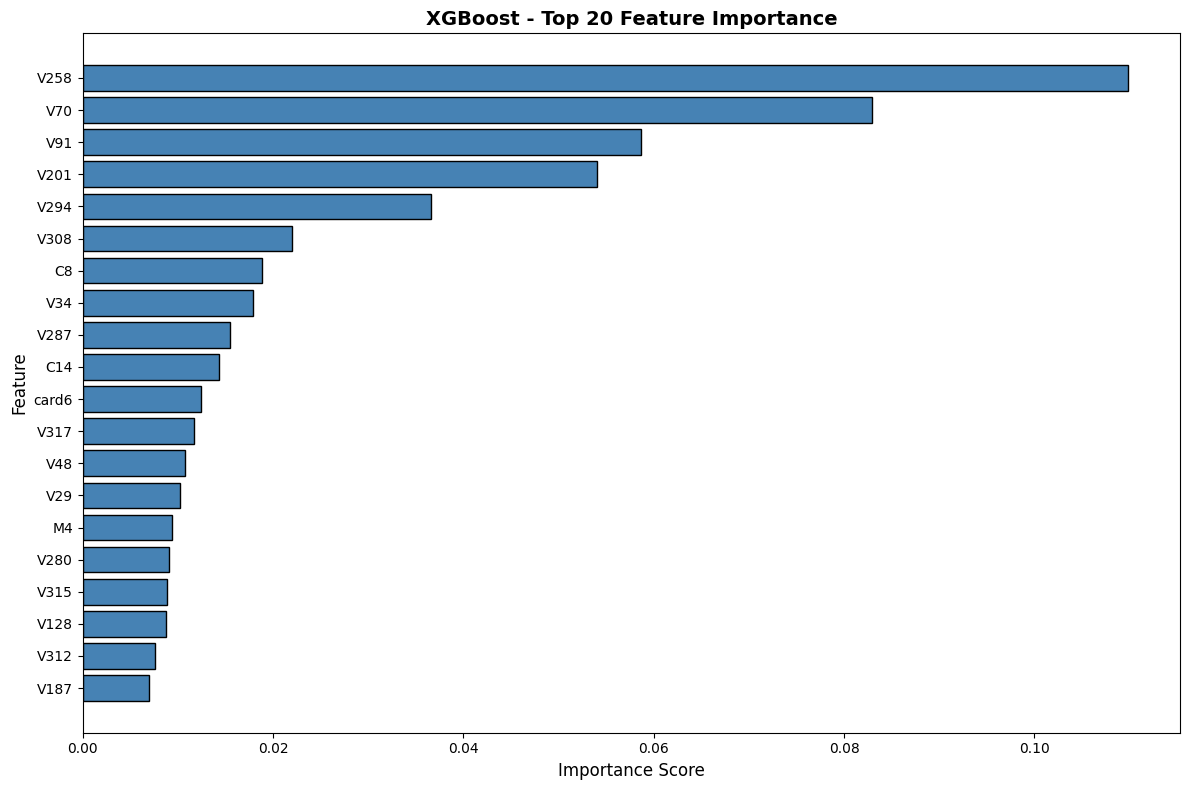


Top 10 Most Important Features:
shape: (10, 2)
┌─────────┬────────────┐
│ Feature ┆ Importance │
│ ---     ┆ ---        │
│ str     ┆ f32        │
╞═════════╪════════════╡
│ V258    ┆ 0.109812   │
│ V70     ┆ 0.08292    │
│ V91     ┆ 0.058696   │
│ V201    ┆ 0.054002   │
│ V294    ┆ 0.036619   │
│ V308    ┆ 0.021997   │
│ C8      ┆ 0.018792   │
│ V34     ┆ 0.017845   │
│ V287    ┆ 0.015439   │
│ C14     ┆ 0.014275   │
└─────────┴────────────┘


In [64]:
# Feature Importance from XGBoost
print("XGBOOST FEATURE IMPORTANCE (Top 20)")
print("=" * 60)

# Get feature importance (use xgb_model, not best_xgb_model)
feature_importance = xgb_model.feature_importances_
feature_names = X_scaled.columns

# Create DataFrame and sort
importance_df = pl.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort('Importance', descending=True)

# Plot top 20 features
top_20 = importance_df.head(20)

plt.figure(figsize=(12, 8))
plt.barh(top_20['Feature'].to_list()[::-1], top_20['Importance'].to_list()[::-1], 
         color='steelblue', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost - Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# 9. Deep Learning Model (TensorFlow/Keras)

In this section, we build a **Multi-Layer Perceptron (MLP)** neural network using TensorFlow/Keras.

## Neural Network Architecture:
- **Input Layer**: Accepts all features
- **Hidden Layers**: Multiple dense layers with ReLU activation
- **Batch Normalization**: Normalizes inputs to each layer
- **Dropout**: Prevents overfitting by randomly dropping neurons
- **Output Layer**: Single neuron with sigmoid activation for binary classification

## Training Strategy:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Binary Cross-Entropy
- **Class Weights**: Applied to handle class imbalance (instead of SMOTE)
- **Callbacks**: Early Stopping and Learning Rate Reduction

In [67]:
# Build Deep Learning Model (TensorFlow/Keras MLP)
print("BUILDING NEURAL NETWORK MODEL (TensorFlow/Keras)")
print("=" * 60)

# Clear any existing models from memory
tf.keras.backend.clear_session()

# Get input dimension
input_dim = X_train_resampled.shape[1]
print(f"Input dimension: {input_dim} features")

# Build the model (without explicit layer names to avoid conflicts)
def build_mlp_model(input_dim):
    """
    Build a Multi-Layer Perceptron for binary classification
    """
    model = Sequential()
    
    # Input Layer
    model.add(Dense(256, activation='relu', input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Hidden Layer 1
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Hidden Layer 2
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Hidden Layer 3
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Create the model
nn_model = build_mlp_model(input_dim)

# Display model summary
print("\nMODEL ARCHITECTURE:")
nn_model.summary()

BUILDING NEURAL NETWORK MODEL (TensorFlow/Keras)
Input dimension: 392 features

MODEL ARCHITECTURE:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,793 (569.50 KB)

 Trainable params: 144,833 (565.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [68]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    mode='max',
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Callbacks defined:")
print("   - EarlyStopping: Stops training if validation AUC doesn't improve for 5 epochs")
print("   - ReduceLROnPlateau: Reduces learning rate if validation AUC plateaus")

Callbacks defined:
   - EarlyStopping: Stops training if validation AUC doesn't improve for 5 epochs
   - ReduceLROnPlateau: Reduces learning rate if validation AUC plateaus


In [69]:
# Train the neural network with class weights
print("TRAINING NEURAL NETWORK")
print("=" * 60)

# Training parameters
EPOCHS = 50
BATCH_SIZE = 256

# Train the model with class weights to handle imbalance
print(f"Using class weights: {class_weight_dict}")
print("This handles class imbalance without creating synthetic data (memory efficient)\n")

history = nn_model.fit(
    X_train_resampled, 
    y_train_resampled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # Apply class weights here!
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

TRAINING NEURAL NETWORK
Using class weights: {0: 0.5181288961224123, 1: 14.290139140955837}
This handles class imbalance without creating synthetic data (memory efficient)

Epoch 1/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7653 - auc: 0.8256 - loss: 0.5130 - val_accuracy: 0.8515 - val_auc: 0.8654 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 2/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8076 - auc: 0.8633 - loss: 0.4568 - val_accuracy: 0.8626 - val_auc: 0.8778 - val_loss: 0.3755 - learning_rate: 0.0010
Epoch 3/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8262 - auc: 0.8750 - loss: 0.4384 - val_accuracy: 0.8599 - val_auc: 0.8853 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 4/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8341 - auc: 0.8834 - loss: 0.4244 - val_accuracy: 0.8934 - val_auc: 0.8901 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 5/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8406 - au

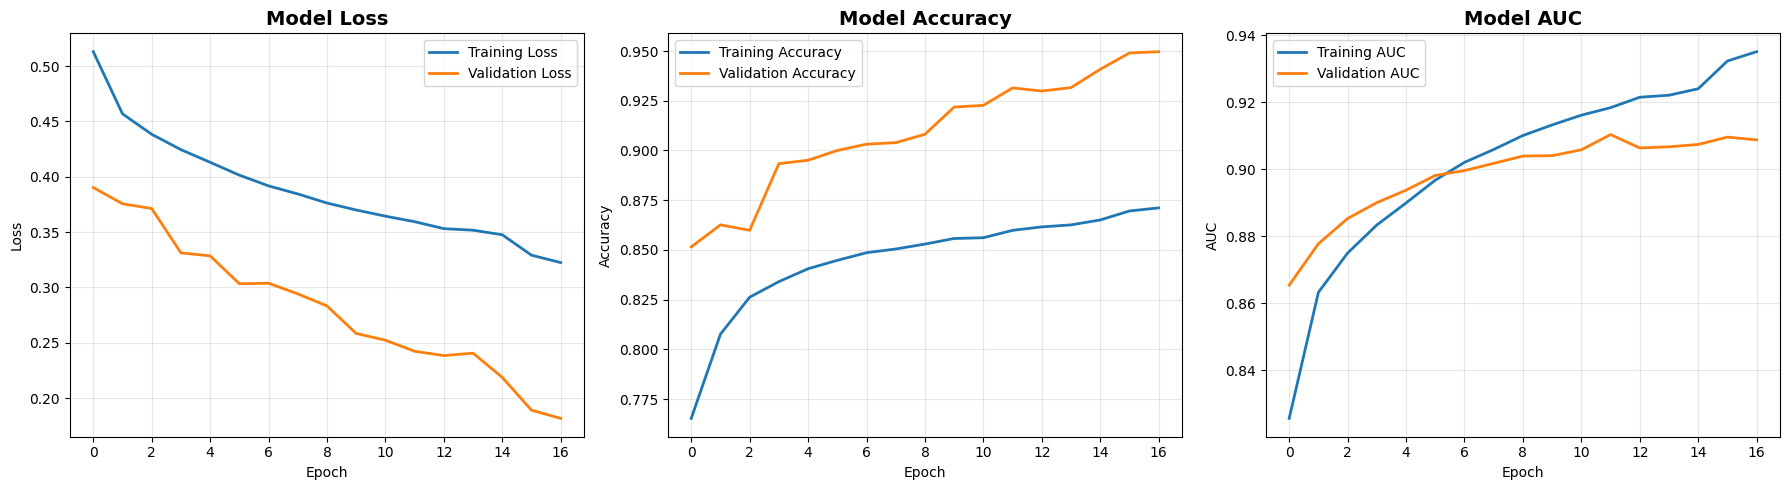

In [70]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [71]:
# Evaluate Neural Network on Validation Set
print("NEURAL NETWORK (TensorFlow) - EVALUATION RESULTS:")
print("=" * 60)

# Predictions
y_pred_proba_nn = nn_model.predict(X_val, verbose=0).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

# Calculate metrics
accuracy_nn = accuracy_score(y_val, y_pred_nn)
precision_nn = precision_score(y_val, y_pred_nn)
recall_nn = recall_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
roc_auc_nn = roc_auc_score(y_val, y_pred_proba_nn)

print(f"   Accuracy:  {accuracy_nn:.4f}")
print(f"   Precision: {precision_nn:.4f}")
print(f"   Recall:    {recall_nn:.4f}")
print(f"   F1-Score:  {f1_nn:.4f}")
print(f"   ROC-AUC:   {roc_auc_nn:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_val, y_pred_nn))

# Add to results
nn_results = {
    'Model': 'Neural Network (TensorFlow)',
    'Accuracy': accuracy_nn,
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1-Score': f1_nn,
    'ROC-AUC': roc_auc_nn
}
results.append(nn_results)
trained_models['Neural Network (TensorFlow)'] = nn_model

NEURAL NETWORK (TensorFlow) - EVALUATION RESULTS:
   Accuracy:  0.9315
   Precision: 0.2948
   Recall:    0.6884
   F1-Score:  0.4128
   ROC-AUC:   0.9104

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    113975
           1       0.29      0.69      0.41      4133

    accuracy                           0.93    118108
   macro avg       0.64      0.81      0.69    118108
weighted avg       0.96      0.93      0.94    118108



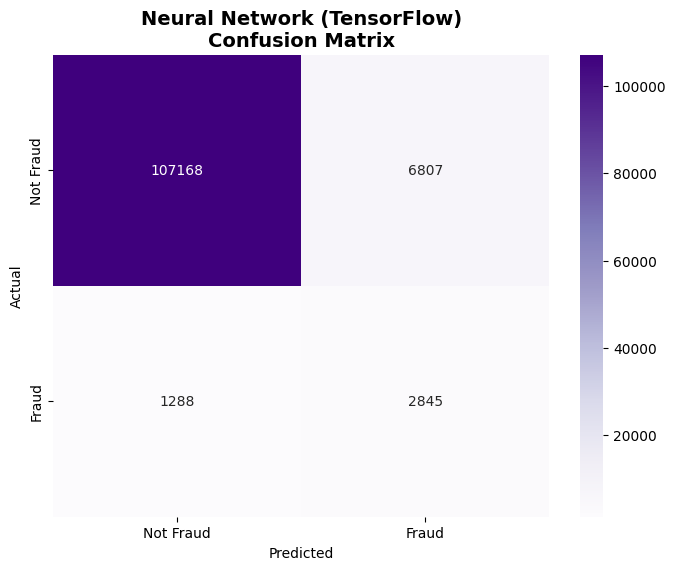

In [72]:
# Confusion Matrix for Neural Network
plt.figure(figsize=(8, 6))

cm_nn = confusion_matrix(y_val, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Neural Network (TensorFlow)\nConfusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 10. Model Comparison


In [73]:
# Create comparison table
print("MODEL COMPARISON TABLE")
print("=" * 80)

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

# Round values for display
results_display = results_df.round(4)

# Style the dataframe for better visualization
print(results_display.to_string())

# Highlight best values
print("\n" + "=" * 80)
print("BEST PERFORMING MODEL FOR EACH METRIC:")
print("=" * 80)
for col in results_df.columns:
    best_model = results_df[col].idxmax()
    best_value = results_df[col].max()
    print(f"   {col:12s}: {best_model} ({best_value:.4f})")

MODEL COMPARISON TABLE
                             Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                                      
Logistic Regression            0.8243     0.1342  0.7372    0.2270   0.8604
Random Forest                  0.9291     0.2897  0.7065    0.4109   0.9110
XGBoost                        0.8847     0.2049  0.7970    0.3260   0.9202
Neural Network (TensorFlow)    0.9315     0.2948  0.6884    0.4128   0.9104

BEST PERFORMING MODEL FOR EACH METRIC:
   Accuracy    : Neural Network (TensorFlow) (0.9315)
   Precision   : Neural Network (TensorFlow) (0.2948)
   Recall      : XGBoost (0.7970)
   F1-Score    : Neural Network (TensorFlow) (0.4128)
   ROC-AUC     : XGBoost (0.9202)


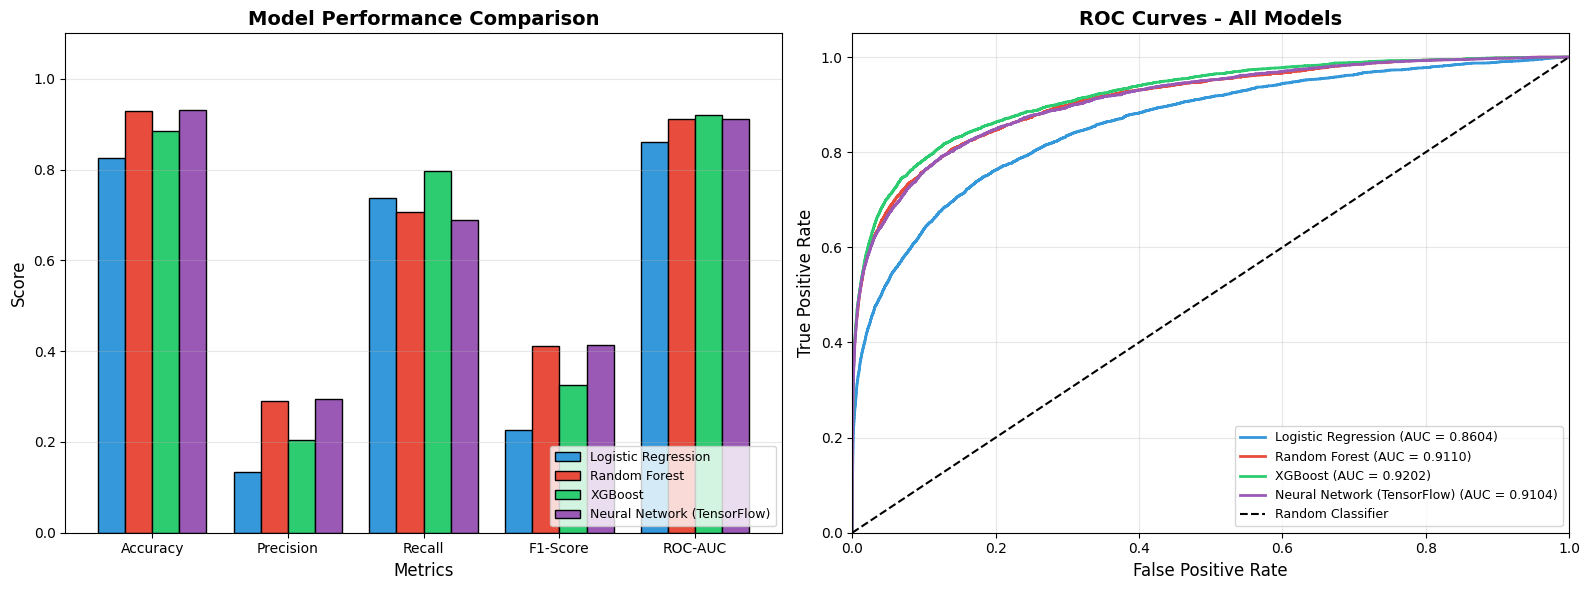

In [74]:
# Visual Comparison of Models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
models = results_df.index.tolist()

for i, model in enumerate(models):
    values = results_df.loc[model, metrics].values
    axes[0].bar(x + i*width, values, width, label=model, color=colors[i % len(colors)], edgecolor='black')

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(metrics)
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3, axis='y')

# ROC Curves for all models
colors_roc = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for idx, (name, model) in enumerate(trained_models.items()):
    # Handle TensorFlow model differently
    if 'TensorFlow' in name or 'Neural Network' in name:
        y_pred_proba = model.predict(X_val, verbose=0).flatten()
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    axes[1].plot(fpr, tpr, color=colors_roc[idx % len(colors_roc)], linewidth=2,
                 label=f'{name} (AUC = {roc_auc:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [75]:
# Select the best model based on ROC-AUC
best_model_name = results_df['ROC-AUC'].idxmax()
best_model_roc_auc = results_df['ROC-AUC'].max()

print("FINAL MODEL SELECTION")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"ROC-AUC Score: {best_model_roc_auc:.4f}")
print()
print("This model will be used for predictions on the test set.")

FINAL MODEL SELECTION

Best Model: XGBoost
ROC-AUC Score: 0.9202

This model will be used for predictions on the test set.


# 10. Test Set Prediction

Now we will use our best-performing model to predict fraud probabilities on the test dataset.

The output will be a DataFrame with:
- **TransactionID**: Unique identifier for each transaction
- **isFraud**: Predicted probability of fraud (0 to 1)

In [76]:
# Make predictions on test set using the best model
print("MAKING PREDICTIONS ON TEST SET")
print("=" * 60)

# Convert test_scaled to numpy for prediction
test_scaled_np = test_scaled.to_numpy()

# Get predictions using the best model
best_model = trained_models[best_model_name]

# Handle TensorFlow model differently
if 'TensorFlow' in best_model_name or 'Neural Network' in best_model_name:
    test_predictions_proba = best_model.predict(test_scaled_np, verbose=0).flatten()
else:
    test_predictions_proba = best_model.predict_proba(test_scaled_np)[:, 1]

print(f"Using model: {best_model_name}")

# Create submission DataFrame using Polars
submission_df = pl.DataFrame({
    'TransactionID': test_transaction_ids,
    'isFraud': test_predictions_proba
})

print(f"\nPredictions completed!")
print(f"   Total predictions: {len(submission_df):,}")
print(f"   Prediction range: [{test_predictions_proba.min():.4f}, {test_predictions_proba.max():.4f}]")
print(f"   Mean probability: {test_predictions_proba.mean():.4f}")

# Display sample predictions
print("\nSAMPLE PREDICTIONS (First 10 rows):")
print(submission_df.head(10))

MAKING PREDICTIONS ON TEST SET
Using model: XGBoost

Predictions completed!
   Total predictions: 506,691
   Prediction range: [0.0065, 0.9979]
   Mean probability: 0.2615

SAMPLE PREDICTIONS (First 10 rows):
shape: (10, 2)
┌───────────────┬──────────┐
│ TransactionID ┆ isFraud  │
│ ---           ┆ ---      │
│ i64           ┆ f32      │
╞═══════════════╪══════════╡
│ 3663549       ┆ 0.072648 │
│ 3663550       ┆ 0.225508 │
│ 3663551       ┆ 0.269565 │
│ 3663552       ┆ 0.090018 │
│ 3663553       ┆ 0.125459 │
│ 3663554       ┆ 0.114454 │
│ 3663555       ┆ 0.410595 │
│ 3663556       ┆ 0.475755 │
│ 3663557       ┆ 0.063645 │
│ 3663558       ┆ 0.229041 │
└───────────────┴──────────┘


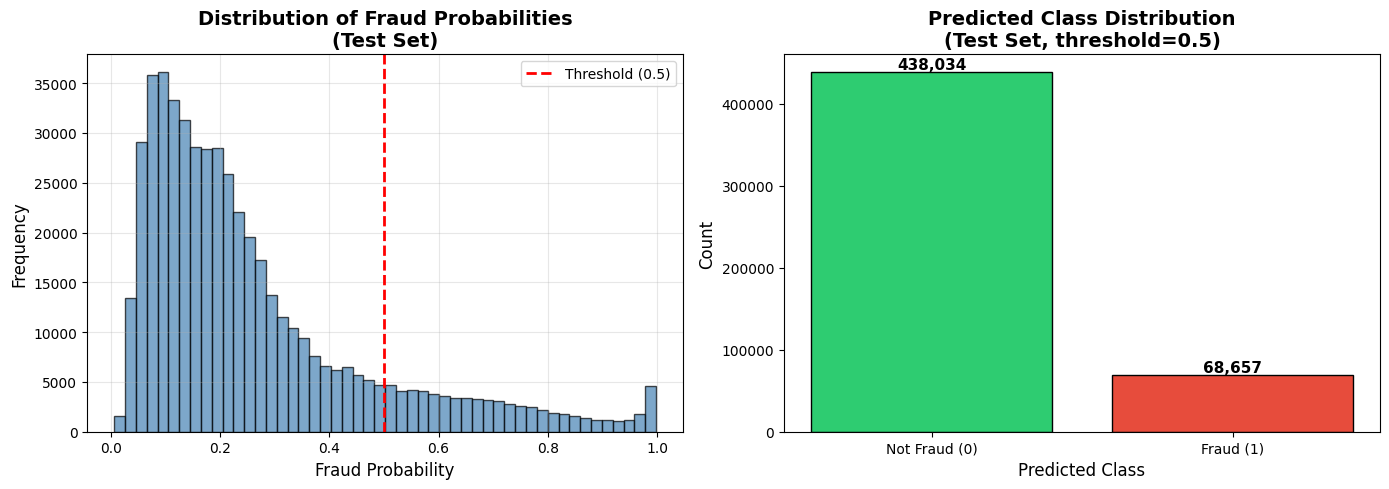


Predicted Class Distribution (threshold=0.5):
   Not Fraud: 438,034 (86.45%)
   Fraud: 68,657 (13.55%)


In [77]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of predictions
axes[0].hist(test_predictions_proba, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Fraud Probability', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Fraud Probabilities\n(Test Set)', fontsize=14, fontweight='bold')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Binary classification distribution (using 0.5 threshold)
predicted_classes = (test_predictions_proba >= 0.5).astype(int)
unique, counts = np.unique(predicted_classes, return_counts=True)
class_counts = dict(zip(unique, counts))

colors = ['#2ecc71', '#e74c3c']
bars = axes[1].bar(['Not Fraud (0)', 'Fraud (1)'], 
                    [class_counts.get(0, 0), class_counts.get(1, 0)], 
                    color=colors, edgecolor='black')
axes[1].set_xlabel('Predicted Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Class Distribution\n(Test Set, threshold=0.5)', fontsize=14, fontweight='bold')

# Add count labels
for bar, count in zip(bars, [class_counts.get(0, 0), class_counts.get(1, 0)]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPredicted Class Distribution (threshold=0.5):")
print(f"   Not Fraud: {class_counts.get(0, 0):,} ({class_counts.get(0, 0)/len(predicted_classes)*100:.2f}%)")
print(f"   Fraud: {class_counts.get(1, 0):,} ({class_counts.get(1, 0)/len(predicted_classes)*100:.2f}%)")

In [78]:
# Save predictions to CSV using Polars (faster)
output_filename = 'fraud_predictions.csv'
submission_df.write_csv(output_filename)

print(f"Predictions saved to '{output_filename}'")
print(f"   File contains {len(submission_df):,} predictions")

# Display final submission DataFrame
print("\nFINAL SUBMISSION DATAFRAME:")
print("=" * 60)
submission_df

Predictions saved to 'fraud_predictions.csv'
   File contains 506,691 predictions

FINAL SUBMISSION DATAFRAME:


TransactionID,isFraud
i64,f32
3663549,0.072648
3663550,0.225508
3663551,0.269565
3663552,0.090018
3663553,0.125459
3663554,0.114454
3663555,0.410595
3663556,0.475755
3663557,0.063645
